## Aprendizaje no supervisado : Clustering

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## KMeans

Nueva columna

In [5]:
X, y = make_blobs(n_samples=500, centers=3, random_state=42, cluster_std=1.0)
X[:5]

array([[-5.73035386, -7.58328602],
       [ 1.94299219,  1.91887482],
       [ 6.82968177,  1.1648714 ],
       [-2.90130578,  7.55077118],
       [ 5.84109276,  1.56509431]])

Text(0.5, 1.0, 'Datos sin etiquetar')

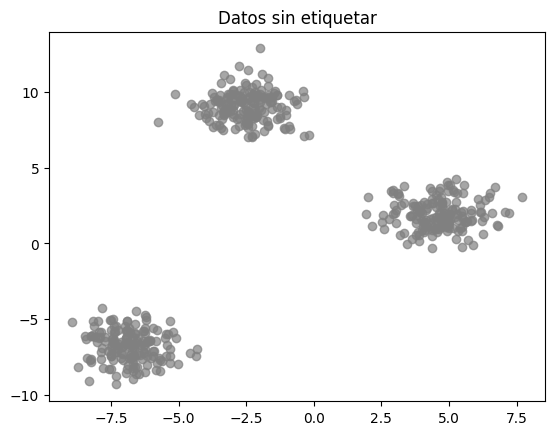

In [7]:
plt.scatter(X[:,0], X[:,1], c='gray', alpha=0.7)
plt.title('Datos sin etiquetar')

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X) #no lleva y


KMeans(n_clusters=3, random_state=42)

In [14]:
from sklearn.metrics import silhouette_score
print('kmeans.labels_:', kmeans.labels_[:10])
print('kmeans.cluster_centers_:', kmeans.cluster_centers_[:10]) #centroides
print('kmeans.inertia_', kmeans.inertia_) #como de bien estan agrupados los datos, nos interesa un dato bajo
print('silohouette_score', silhouette_score(X, kmeans.labels_))


kmeans.labels_: [1 0 0 2 0 0 1 0 0 1]
kmeans.cluster_centers_: [[ 4.61416263  1.93184055]
 [-6.83120002 -6.75657544]
 [-2.51336974  9.03492867]]
kmeans.inertia_ 955.6493433489619
silohouette_score 0.8437565906781406


Text(0.5, 1.0, 'Datos etiquetados por Kmeans')

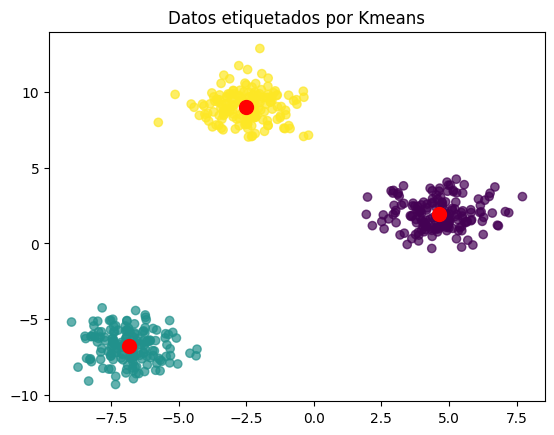

In [ ]:
#dibujar centroides y los clusters
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, alpha=0.7, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100)
plt.title('Datos etiquetados por Kmeans')


Text(0.5, 1.0, 'Conteo de Clusters')

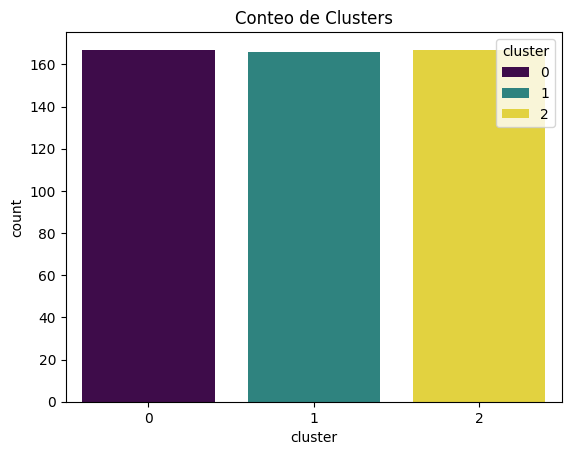

In [20]:
#countplot de los clusters
df_labels = pd.DataFrame({'cluster': kmeans.labels_})
sns.countplot(df_labels, x= 'cluster', palette='viridis', hue='cluster')
plt.title('Conteo de Clusters')

In [22]:
from sklearn.metrics import accuracy_score, classification_report
#porbar accuracy, en un caso real se supone que no tendriamos la 'y' por lo que no podriamos hacerlo
#accuracy_score(y, kmeans.labels_)
print(classification_report(y, df_labels['cluster']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     167.0
           1       0.00      0.00      0.00     167.0
           2       0.00      0.00      0.00     166.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0



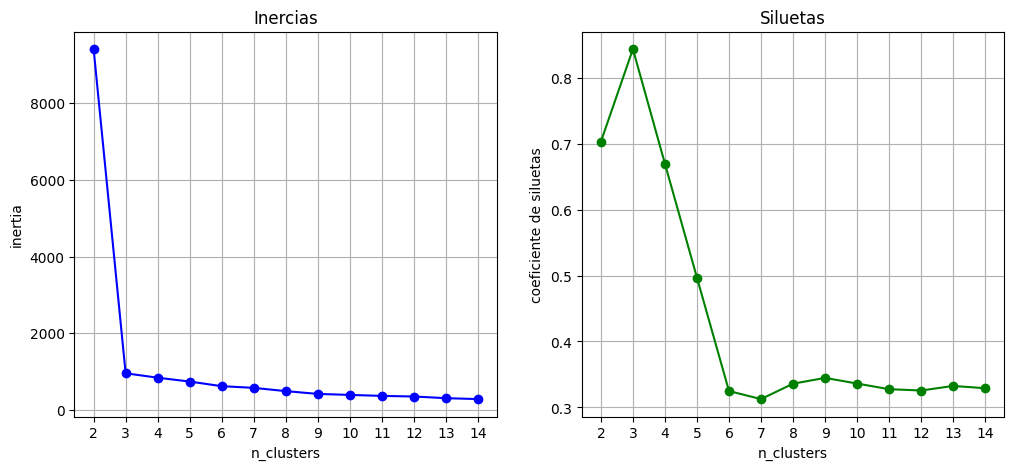

In [26]:
## eleccion del numero optimo K o n_clusters

### Metodo del codo

inertias =[]
siluetas = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    siluetas.append(silhouette_score(X, kmeans.labels_))
    
plt.figure(figsize=(12,5))

plt.subplot(1,2, 1)
plt.plot(k_range, inertias, marker='o', color= 'blue')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.title ('Inercias')
plt.xticks(k_range)
plt.grid(True)
    
plt.subplot(1,2, 2)
plt.plot(k_range, siluetas, marker='o', color= 'green')
plt.xlabel('n_clusters')
plt.ylabel('coeficiente de siluetas')
plt.title ('Siluetas')
plt.xticks(k_range)
plt.grid(True);

K-Means (Iris) -> Inercia: 78.86
K-Means (Iris) -> Coeficiente de Silueta: 0.55


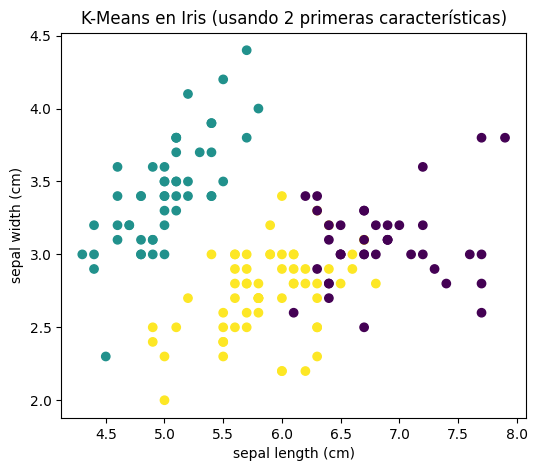

In [27]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
iris = load_iris()
X_iris = iris.data 
y_iris_true = iris.target  # Etiquetas reales (Setosa, Versicolor, Virginica)
feature_names = iris.feature_names

#scaler = StandardScaler()
#X_scaler = scaler.fit_transform(X_iris)
kmeans_iris = KMeans(n_clusters=3, random_state=42)
kmeans_iris.fit(X_iris)
labels_kmeans_iris = kmeans_iris.labels_
inertia_kmeans_iris = kmeans_iris.inertia_
silhouette_kmeans_iris = silhouette_score(X_iris, labels_kmeans_iris)
print(f"K-Means (Iris) -> Inercia: {inertia_kmeans_iris:.2f}")
print(f"K-Means (Iris) -> Coeficiente de Silueta: {silhouette_kmeans_iris:.2f}")
plt.figure(figsize=(6, 5))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=labels_kmeans_iris, cmap='viridis')
plt.title("K-Means en Iris (usando 2 primeras características)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

In [29]:
print(classification_report(y_iris_true, kmeans_iris.labels_))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.23      0.28      0.25        50

    accuracy                           0.09       150
   macro avg       0.08      0.09      0.08       150
weighted avg       0.08      0.09      0.08       150



DBSCAN es un algoritmo de clustering basado en densidad. A diferencia de otros métodos como *k-means*, que necesita que especifiquemos el número de clusters, DBSCAN funciona explorando la estructura de densidad de los datos. 

En otras palabras, DBSCAN agrupa juntos puntos que están “cerca” unos de otros (según un criterio de densidad) y considera como ruido a los puntos que no cumplen ese criterio.


1. **Parámetros principales**:
   - **$\epsilon$ (eps)**: Es un radio de vecindad. Básicamente, indica la distancia máxima que se considerará para que dos puntos estén “cerca”. Si ϵ es demasiado pequeño, muchos puntos se marcan como “ruido” porque casi no tienen vecinos dentro del radio. Si es demasiado grande, varios grupos distintos podrían unificarse en un solo cluster.
   - **min_samples**: Número mínimo de puntos necesarios para considerar que un grupo de puntos (una “región”) es un cluster denso. Por ejemplo, si `min_samples=5`, al menos 5 puntos deben estar dentro del radio $\epsilon$ para formar un cluster.

2. **Clases de puntos**:
   - **Punto “central”** (core point): Es aquel que tiene al menos `min_samples` puntos (incluyéndose a sí mismo) dentro del radio $\epsilon$.
   - **Punto “alcanzable por densidad”** (density-reachable): No es un punto central, pero está a menos de $\epsilon$ de un punto central.
   - **Ruido (noise point)**: No es ni punto central ni alcanzable por densidad. Por lo tanto, no pertenece a ningún cluster y se considera “ruido” o “outlier”.

3. **Proceso del algoritmo**:
   - Se comienza con un punto que no ha sido visitado.
   - Se obtienen todos los puntos que están a menos de $\epsilon$ de ese punto. Si no se alcanza el umbral `min_samples`, ese punto se marca como ruido (aunque podría luego reclasificarse si se descubre que está dentro de un radio $\epsilon$ de un punto central).
   - Si se alcanza el umbral `min_samples`, se crea un nuevo cluster y se “propaga” por todos los puntos que están dentro del radio $\epsilon$ de ese punto, buscando nuevos puntos centrales y sus vecinos (ampliando así el cluster).
   - Se repite el proceso hasta que todos los puntos hayan sido visitados, asignándolos al cluster correspondiente o marcándolos como ruido.

Ventajas:

* No requiere especificar de antemano el número de clusters.
* Puede encontrar clusters de formas arbitrarias (no sólo esféricos como en KMeans).
* Identifica puntos atípicos (ruido) fácilmente.

Desventajas:

* Requiere ajustar los parámetros epsilon y min_samples, los cuales pueden variar mucho dependiendo del conjunto de datos.
* Si los datos tienen distinta densidad en distintas regiones, un solo valor de epsilon puede no ser óptimo para todas las zonas, lo que dificulta encontrar un buen equilibrio.

In [56]:
from sklearn.cluster import DBSCAN

X, y = make_blobs(n_samples=500, centers=3, random_state=42, cluster_std=1.0)

# dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(X)

# DBSCAN no tiene inertia_
print('labels', dbscan.labels_[:15]) # contiene -1 en aquellas muestras que considera outliers similar a IsolationForest

labels [0 1 1 2 1 1 0 1 1 0 1 2 2 2 1]


In [57]:
filtro = (dbscan.labels_ != -1) # Filtramos outliers para poder calcular siluetas
silhouette_score(X[filtro], dbscan.labels_[filtro]) # cuanto más cercano a 1 mejor

np.float64(0.8443450328221088)

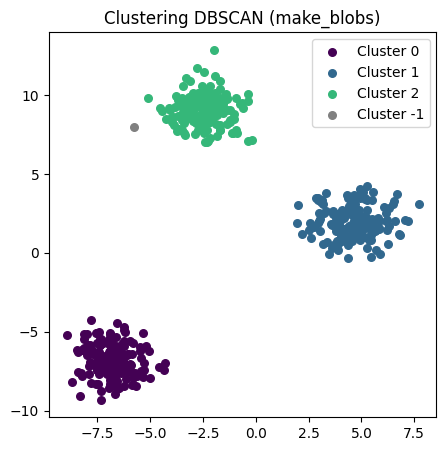

In [58]:
import numpy as np 
unique_labels = set(dbscan.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(5, 5))
# Asignamos un color distinto para el cluster -1 (puntos considerados outliers)
unique_labels = set(dbscan.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
for label, col in zip(unique_labels, colors):
    class_member_mask = (dbscan.labels_ == label)
    if label == -1:
        # Color gris para outliers
        col = 'gray'
    plt.scatter(X[class_member_mask, 0], X[class_member_mask, 1], 
                c=[col], s=30, label=f"Cluster {label}")
plt.title("Clustering DBSCAN (make_blobs)")
plt.legend()
plt.show()

In [32]:
from sklearn.datasets import load_iris
iris = load_iris()
X_iris = iris.data  
y_iris_true = iris.target 
feature_names = iris.feature_names
dbscan_iris = DBSCAN(eps=0.5, min_samples=5)
dbscan_iris.fit(X_iris)

DBSCAN()

DBSCAN (Iris) -> Coeficiente de Silueta (núcleos): 0.74


Text(0, 0.5, 'sepal width (cm)')

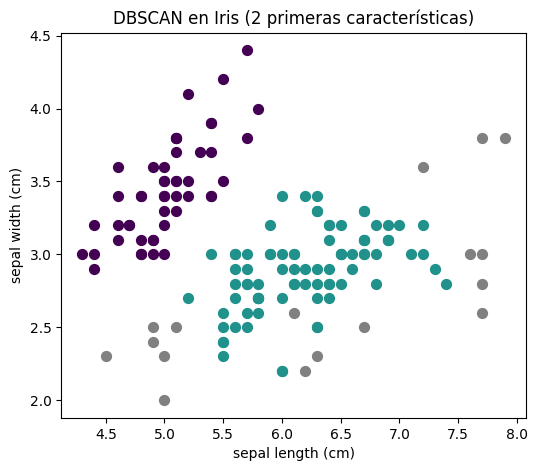

In [35]:
labels_dbscan_iris = dbscan_iris.labels_
mask_core_iris = labels_dbscan_iris != -1
if np.sum(mask_core_iris) > 1:
    silhouette_dbscan_iris = silhouette_score(X_iris[mask_core_iris], labels_dbscan_iris[mask_core_iris])
    print(f"DBSCAN (Iris) -> Coeficiente de Silueta (núcleos): {silhouette_dbscan_iris:.2f}")
else:
    silhouette_dbscan_iris = None
    print("DBSCAN (Iris) -> No se pudo calcular silueta, pocos puntos en clusters.")

plt.figure(figsize=(6, 5))
unique_labels_iris = set(labels_dbscan_iris)
colors_iris = plt.cm.viridis(np.linspace(0, 1, len(unique_labels_iris)))
for label, col in zip(unique_labels_iris, colors_iris):
    class_member_mask_iris = (labels_dbscan_iris == label)
    if label == -1:
        col = 'gray'
    plt.scatter(X_iris[class_member_mask_iris, 0], X_iris[class_member_mask_iris, 1], 
                c=[col], s=50, label=f"Cluster {label}")
plt.title("DBSCAN en Iris (2 primeras características)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

## AgglomerativeClustering

El *clustering jerárquico* es un conjunto de métodos de agrupamiento (clustering) que buscan construir una **jerarquía** de clusters. 

El resultado se suele representar con un **dendrograma**, que es una especie de árbol que muestra cómo los puntos se van agrupando (o separando) a medida que cambiamos el nivel de similitud.

A diferencia de otros métodos de clustering como *k-means*, **no** necesitamos especificar de antemano el número de clusters. Podemos, a posteriori, “cortar” el dendrograma al nivel deseado para obtener la cantidad de grupos que necesitamos.

### Dos enfoques: aglomerativo vs. divisivo

1. **Enfoque aglomerativo (bottom-up)**: 
   - Empieza con cada punto siendo su propio cluster (un cluster por cada muestra).
   - En cada paso, se **unen** los dos clusters más similares (o más cercanos).
   - Va “agrupando” hasta quedar en un solo cluster (o en los clusters que consideremos convenientes).
   - Es el más utilizado en la práctica.

2. **Enfoque divisivo (top-down)**:
   - Parte de **un único cluster** con todos los puntos.
   - En cada paso, se **divide** el cluster más heterogéneo en dos clusters según algún criterio, y así sucesivamente.
   - Es menos común y a menudo más costoso computacionalmente que el aglomerativo.

Generalmente, cuando hablamos de *clustering jerárquico* en la práctica, nos referimos al **enfoque aglomerativo**.

### Métrica de distancia y el criterio de enlace (linkage)

Para poder agrupar puntos, necesitamos medir la “distancia” o “similitud” entre ellos. 

Además, al agrupar clusters, también necesitamos medir la distancia entre los clusters ya formados. Esto se hace mediante dos conceptos:

1. **Métrica de distancia**:
   - Puede ser, por ejemplo, la distancia euclidiana, Manhattan, coseno, etc., dependiendo del dominio del problema y de la naturaleza de los datos.
   - Scikit-learn, por defecto, suele usar distancia euclidiana.

2. **Linkage (criterio de enlace)**:
   - Indica cómo calculamos la distancia entre dos clusters. Los criterios más comunes son:
     - **Single linkage** (enlace sencillo): la distancia entre dos clusters es la distancia **mínima** entre cualquier par de puntos (uno de cada cluster).
     - **Complete linkage** (enlace completo): la distancia entre dos clusters es la distancia **máxima** entre cualquier par de puntos.
     - **Average linkage** (enlace promedio): la distancia entre dos clusters es el **promedio** de todas las distancias entre pares de puntos (uno de cada cluster).
     - **Ward**: minimiza el incremento de la suma de cuadrados intra-cluster si se fusionan dos clusters (usa la varianza como criterio). Es muy popular para datos numéricos con distancia euclidiana.

El **Ward linkage** a menudo se recomienda cuando los datos tienen una escala continua y se busca un criterio similar a lo que hace *k-means* (minimizar la varianza dentro de los grupos).

El funcionamiento se suele representar en un **dendrograma**. A medida que se sube en el dendrograma, más clusters se van uniendo. Podemos “cortar” el dendrograma a un cierto nivel de altura para obtener un número determinado de clusters.

'              precision    recall  f1-score   support\n\n           0       0.65      0.69      0.67      5034\n           1       0.67      0.63      0.65      4966\n\n    accuracy                           0.66     10000\n   macro avg       0.66      0.66      0.66     10000\nweighted avg       0.66      0.66      0.66     10000\n'

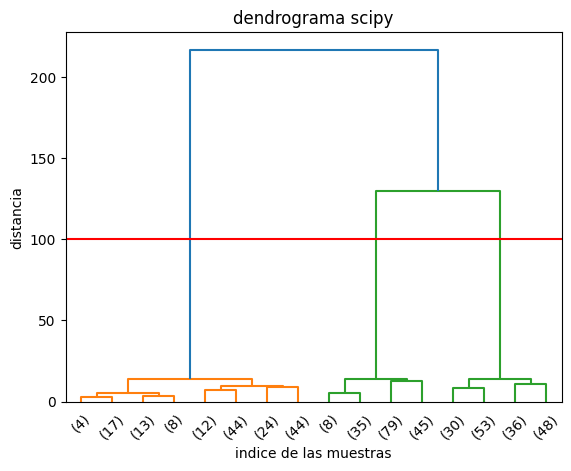

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram

#clistering aglomrativo pero con scipy en vez de con scikit
Z = linkage(X, method='ward')

#dendrogram(Z)
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45, leaf_font_size=10)
plt.axhline(y=100, c='red')
plt.title('dendrograma scipy')
plt.xlabel ('indice de las muestras')
plt.ylabel('distancia');

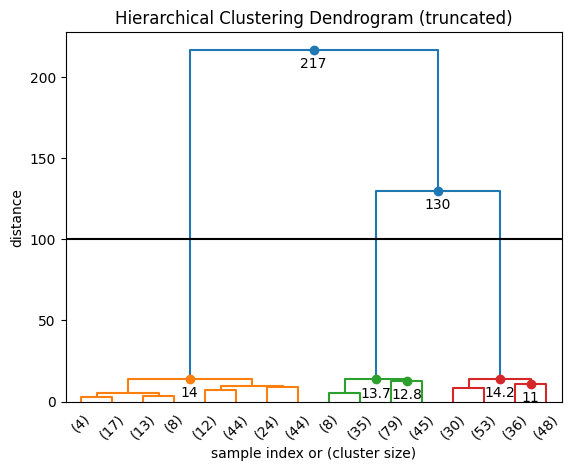

In [43]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

fancy_dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45, leaf_font_size=10, max_d=100, annotate_above=10);

In [44]:
#otra forma de obtener los labels es directamente con fit_predict

cluster = clusterizer.fir_predict(X)
cluster[:10] # lo mismo que con clusterizer.labels_

NameError: name 'clusterizer' is not defined

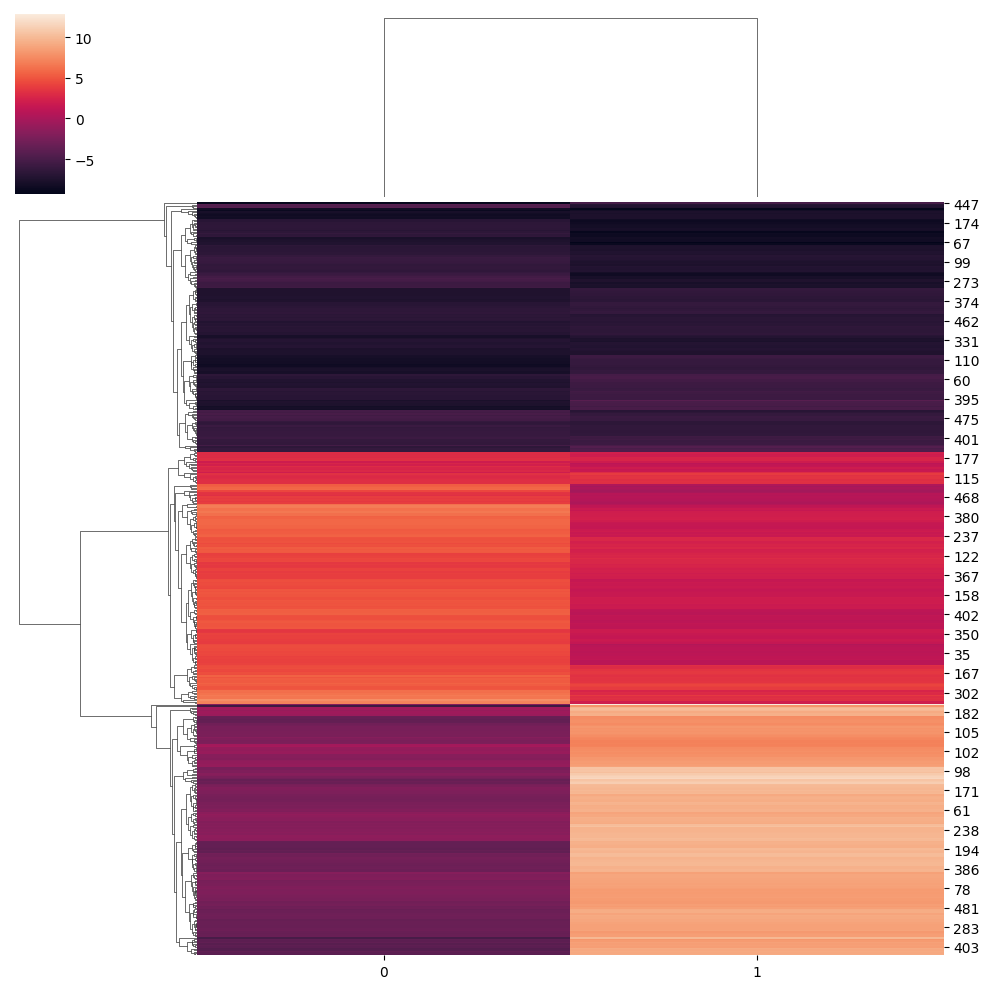

In [46]:
sns.clustermap(X, )

Agglomerative (Iris) -> Coeficiente de Silueta: 0.55


Text(0, 0.5, 'sepal width (cm)')

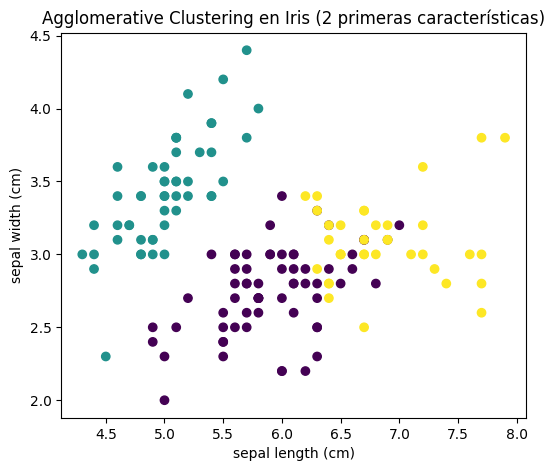

In [47]:
iris = load_iris()
X_iris = iris.data  
y_iris_true = iris.target 
feature_names = iris.feature_names
agg_iris = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_iris.fit(X_iris)
labels_agg_iris = agg_iris.labels_
silhouette_agg_iris = silhouette_score(X_iris, labels_agg_iris)
print(f"Agglomerative (Iris) -> Coeficiente de Silueta: {silhouette_agg_iris:.2f}")
plt.figure(figsize=(6, 5))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=labels_agg_iris, cmap='viridis')
plt.title("Agglomerative Clustering en Iris (2 primeras características)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

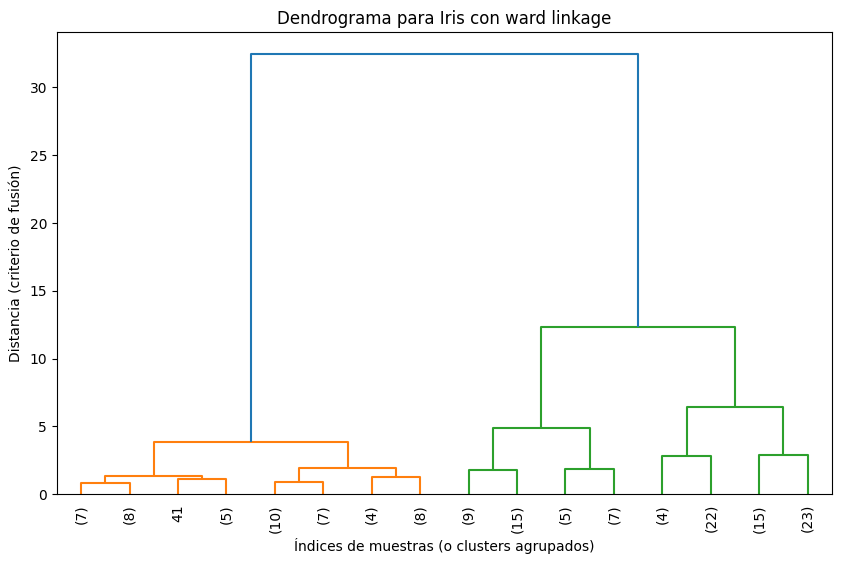

In [54]:
Z = linkage(X_iris, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    truncate_mode='level',  # Modo de truncamiento (opcional)
    p=3,                    # Profundidad de niveles a mostrar
    leaf_rotation=90.,      # Rotar las etiquetas del eje x
    leaf_font_size=10.      # Tamaño de fuente de las etiquetas
)
plt.title("Dendrograma para Iris con ward linkage")
plt.xlabel("Índices de muestras (o clusters agrupados)")
plt.ylabel("Distancia (criterio de fusión)")
plt.show()

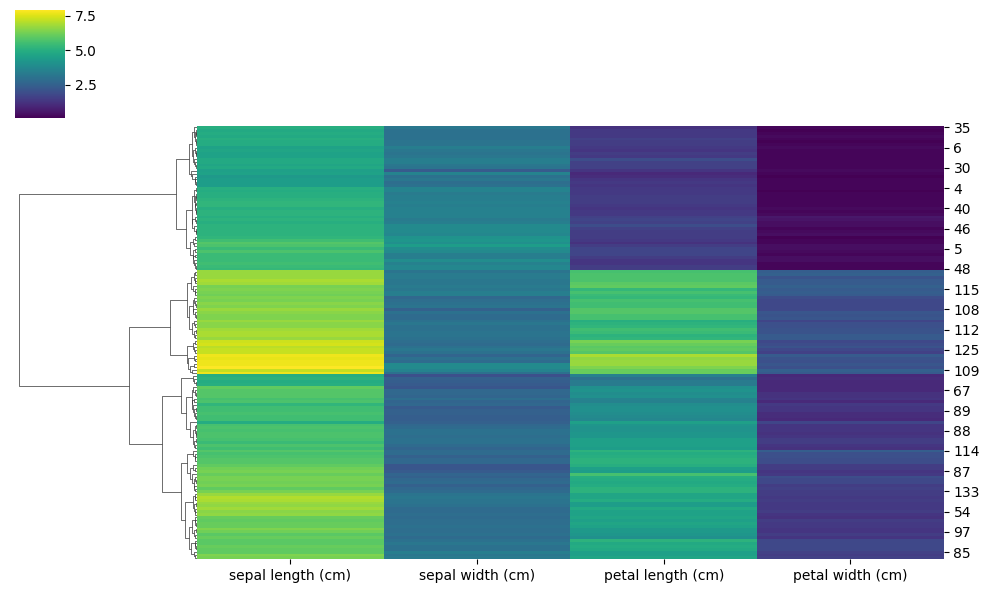

In [55]:
df_iris = pd.DataFrame(X_iris, columns=iris.feature_names)
sns.clustermap(df_iris, row_linkage=Z, cmap='viridis', col_cluster=False, figsize=(10,6))

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
